# COM510 - Redes Neurais

## Exercício de Apoio - Semana 04

### Desenvolvimento de uma rede MLP e melhorias

- Carregamento dos pacotes necessários
- Geração dos dados
- Adição do momentum
- Algoritmos otimizados
- Regularização
- Exercício de Apoio

# Pacotes

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


# Dados

## Geração dos Dados

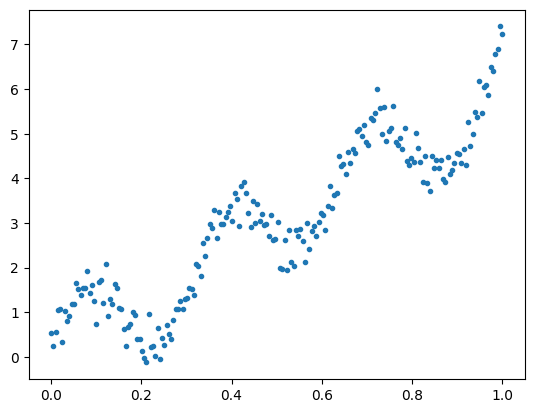

(200,)


In [5]:
np.random.seed(0)
X = np.arange(0,20,0.1)
Y = np.sin(X) + 0.3*np.random.randn(X.shape[0]) + 0.3*X

X = X / np.max(X)
# Y = Y / np.max(Y)
plt.plot(X,Y, '.')
plt.show()
print(X.shape)

## Separação Treino/Validação/Teste

(30, 1)
(30, 1)
(140, 1)


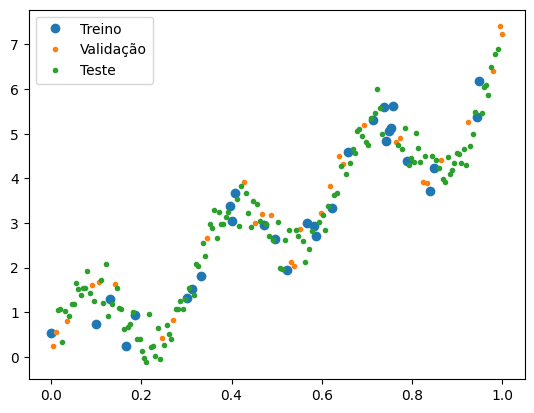

In [7]:
X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

# Separação desenvolvimento (30) e teste (70)
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.7, random_state=3)

# Separação treino (80) e validação (20)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.5, random_state=3)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

plt.plot(X_train, Y_train, 'o', label='Treino')
plt.plot(X_val, Y_val, '.', label='Validação')
plt.plot(X_test, Y_test, '.', label='Teste')
plt.legend()
plt.show()

## Transformação dos dados em tensores Pytorch

In [8]:
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(Y_train)

x_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(Y_val)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(Y_test)


# Modelo 01

In [9]:
class MLP(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLP,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim,512),
            nn.Tanh(),
            nn.Linear(512,256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,output_dim),
        )
    def forward(self,x):
        out =  self.rede(x)
        return out

## Instanciação do Modelo

In [10]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes

modelo = MLP(input_dim,output_dim)

In [11]:
from torchsummary import summary

print(modelo)
summary(modelo, (1,1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]           1,024
              Tanh-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              Tanh-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
              Tanh-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
              Tanh-8  

## Treinamento

### Otimizador e Função de Custo

In [12]:
eta = 0.02
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(modelo.parameters(),lr=eta)

In [13]:
# verificando disponibilidade da gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Laço de treinamento da rede




In [14]:
def train_network(model,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses):
    for epoch in range(num_epochs):
        # zerando os gradientes da época anterior
        optimizer.zero_grad()
        
        # fase de propagação
        output_train = model(x_train)

        # cálculo do erro (função de custo - loss function)
        loss_train = loss_function(output_train, y_train)

        # fase de retroprogação
        loss_train.backward()

        # atualização dos pesos da rede
        optimizer.step()

        # avaliando o modelo com o conjunto de validação
        output_val = model(x_val)
        loss_val = loss_function(output_val,y_val)

        train_losses[epoch] = loss_train.item()
        val_losses[epoch] = loss_val.item()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Erro Treino: {loss_train.item():.4f},  Erro Validação: {loss_val.item():.3f}")

In [16]:
num_epochs = 10000
train_losses = np.zeros(num_epochs)
val_losses  = np.zeros(num_epochs)

train_network(modelo,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses)

Epoch 500/10000, Erro Treino: 0.4781,  Erro Validação: 0.700
Epoch 1000/10000, Erro Treino: 0.4243,  Erro Validação: 0.738
Epoch 1500/10000, Erro Treino: 0.3423,  Erro Validação: 0.820
Epoch 2000/10000, Erro Treino: 0.2412,  Erro Validação: 0.746
Epoch 2500/10000, Erro Treino: 0.2220,  Erro Validação: 0.692
Epoch 3000/10000, Erro Treino: 0.2184,  Erro Validação: 0.685
Epoch 3500/10000, Erro Treino: 0.2154,  Erro Validação: 0.690
Epoch 4000/10000, Erro Treino: 0.2114,  Erro Validação: 0.690
Epoch 4500/10000, Erro Treino: 0.2067,  Erro Validação: 0.678
Epoch 5000/10000, Erro Treino: 0.1998,  Erro Validação: 0.648
Epoch 5500/10000, Erro Treino: 0.1809,  Erro Validação: 0.563
Epoch 6000/10000, Erro Treino: 0.1140,  Erro Validação: 0.374
Epoch 6500/10000, Erro Treino: 0.0788,  Erro Validação: 0.285
Epoch 7000/10000, Erro Treino: 0.0742,  Erro Validação: 0.251
Epoch 7500/10000, Erro Treino: 0.0726,  Erro Validação: 0.241
Epoch 8000/10000, Erro Treino: 0.0723,  Erro Validação: 0.221
Epoch 850

## Resultados

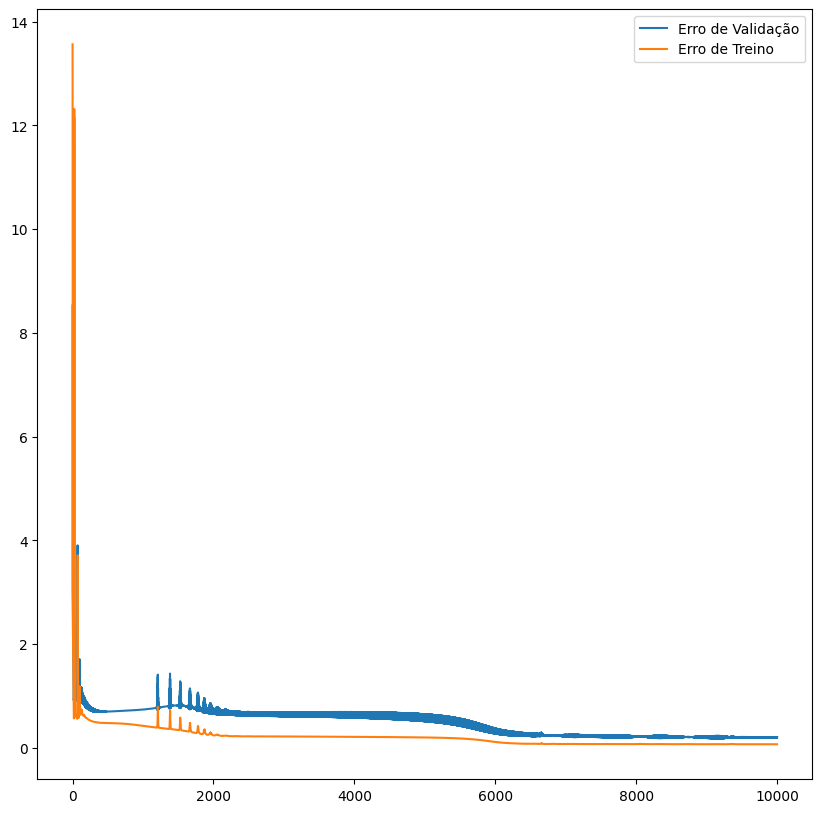

In [17]:
plt.figure(figsize=(10,10))
plt.plot(val_losses, label='Erro de Validação')
plt.plot(train_losses, label='Erro de Treino')
plt.legend()
plt.show()

In [18]:
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = modelo(x_train)
    predictions_val = modelo(x_val)
    predictions_test = modelo(x_test)

erro_train = loss_function(predictions_train,y_train)
erro_val = loss_function(predictions_val,y_val)
erro_test = loss_function(predictions_test,y_test)

print(f"Erro de Treino: {erro_train}")
print(f"Erro de Validação: {erro_val}")
print(f"Erro de Teste: {erro_test}")

Erro de Treino: 0.06860265880823135
Erro de Validação: 0.2045196145772934
Erro de Teste: 0.19557905197143555


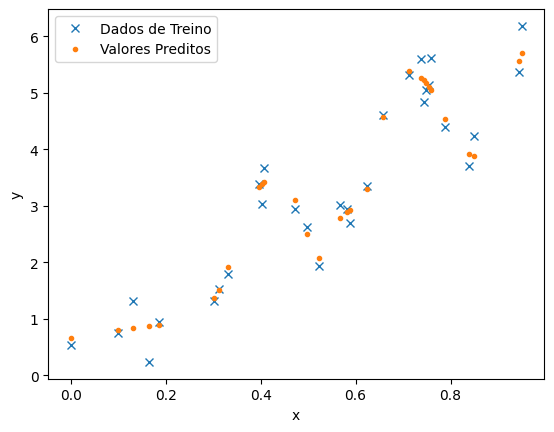

In [19]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

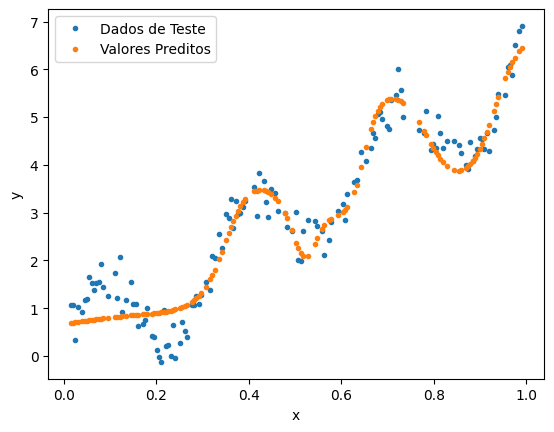

In [20]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

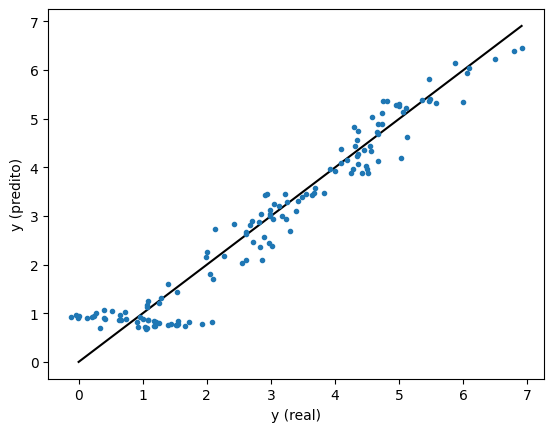

In [21]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

# Modelo 02 (Momentum)

### Instanciação do Modelo 02

In [22]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo2 = MLP(input_dim,output_dim)

### Otimizador

In [23]:
eta = 0.02
mom = 0.5 # momentum
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(modelo2.parameters(),lr=eta, momentum=mom)
# optimizer = torch.optim.SGD(modelo2.parameters(),lr=eta)

### Treinamento

In [24]:
num_epochs = 10000
train_losses2 = np.zeros(num_epochs)
val_losses2  = np.zeros(num_epochs)

train_network(modelo2,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses2,val_losses2)

Epoch 500/10000, Erro Treino: 0.4495,  Erro Validação: 0.725
Epoch 1000/10000, Erro Treino: 0.2672,  Erro Validação: 0.704
Epoch 1500/10000, Erro Treino: 0.0911,  Erro Validação: 0.261
Epoch 2000/10000, Erro Treino: 0.0831,  Erro Validação: 0.227
Epoch 2500/10000, Erro Treino: 0.0801,  Erro Validação: 0.212
Epoch 3000/10000, Erro Treino: 0.0784,  Erro Validação: 0.202
Epoch 3500/10000, Erro Treino: 0.0771,  Erro Validação: 0.196
Epoch 4000/10000, Erro Treino: 0.0761,  Erro Validação: 0.188
Epoch 4500/10000, Erro Treino: 0.0752,  Erro Validação: 0.182
Epoch 5000/10000, Erro Treino: 0.0754,  Erro Validação: 0.164
Epoch 5500/10000, Erro Treino: 0.0772,  Erro Validação: 0.158
Epoch 6000/10000, Erro Treino: 0.0765,  Erro Validação: 0.156
Epoch 6500/10000, Erro Treino: 0.0757,  Erro Validação: 0.154
Epoch 7000/10000, Erro Treino: 0.0748,  Erro Validação: 0.152
Epoch 7500/10000, Erro Treino: 0.0735,  Erro Validação: 0.151
Epoch 8000/10000, Erro Treino: 0.0716,  Erro Validação: 0.156
Epoch 850

## Resultados Modelo 02

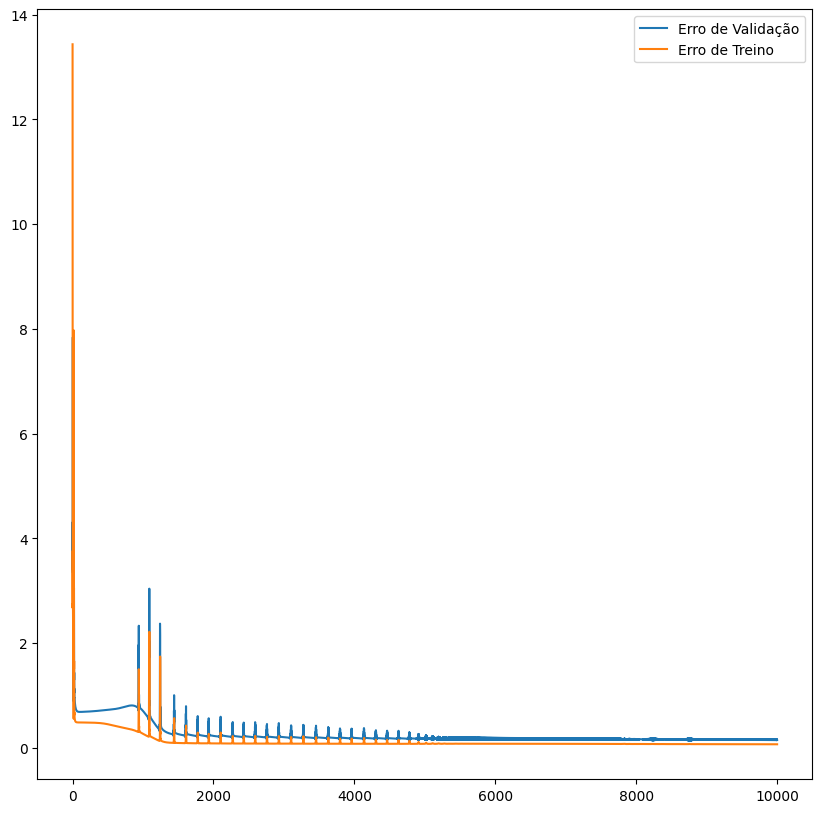

In [25]:
plt.figure(figsize=(10,10))
plt.plot(val_losses2, label='Erro de Validação')
plt.plot(train_losses2, label='Erro de Treino')
plt.legend()
plt.show()

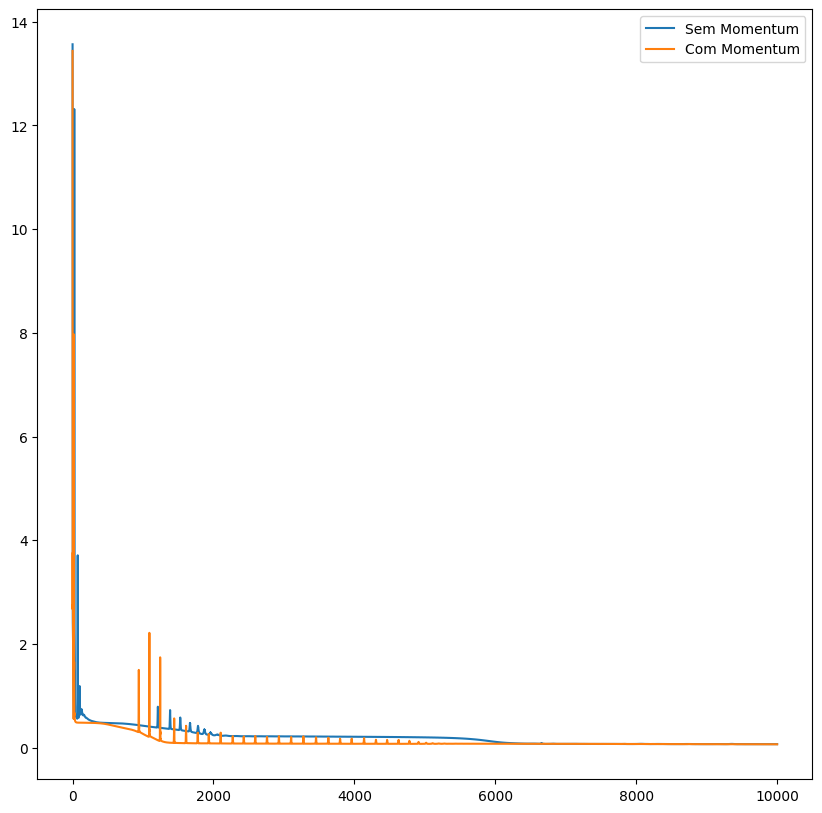

In [26]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Sem Momentum')
plt.plot(train_losses2, label='Com Momentum')
plt.legend()
plt.show()

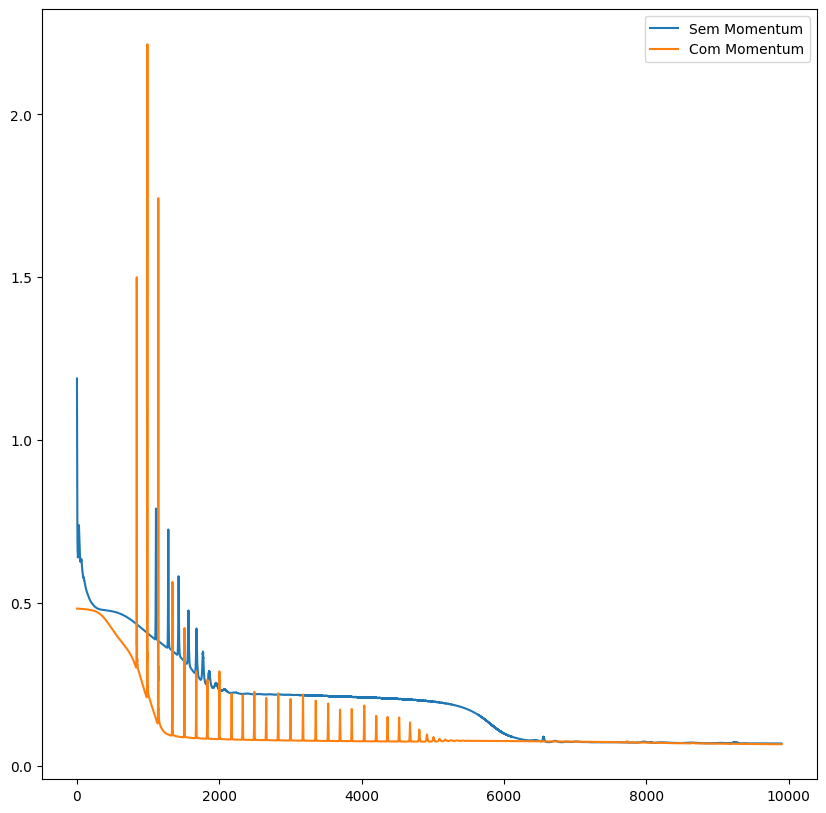

In [27]:
plt.figure(figsize=(10,10))
plt.plot(train_losses[100:], label='Sem Momentum')
plt.plot(train_losses2[100:], label='Com Momentum')
plt.legend()
plt.show()

In [28]:
predictions_train2 = []
predictions_val2 = []
predictions_test2 =  []
with torch.no_grad():
    predictions_train2 = modelo2(x_train)
    predictions_val2 = modelo2(x_val)
    predictions_test2 = modelo2(x_test)

erro_train2 = loss_function(predictions_train2,y_train)
erro_val2 = loss_function(predictions_val2,y_val)
erro_test2 = loss_function(predictions_test2,y_test)

print(f"Erro de Treino: {erro_train2}")
print(f"Erro de Validação: {erro_val2}")
print(f"Erro de Teste: {erro_test2}")

Erro de Treino: 0.0666288509964943
Erro de Validação: 0.14735421538352966
Erro de Teste: 0.18262925744056702


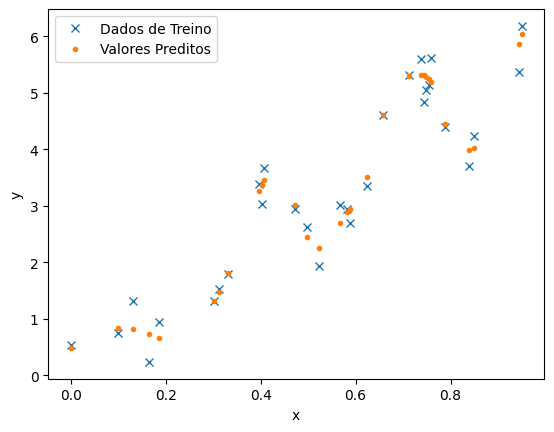

In [29]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train2, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

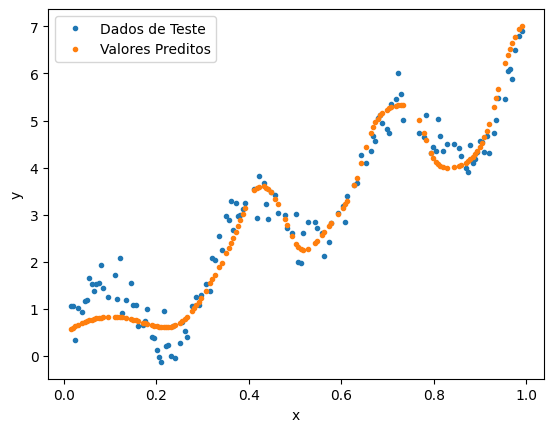

In [30]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test2, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

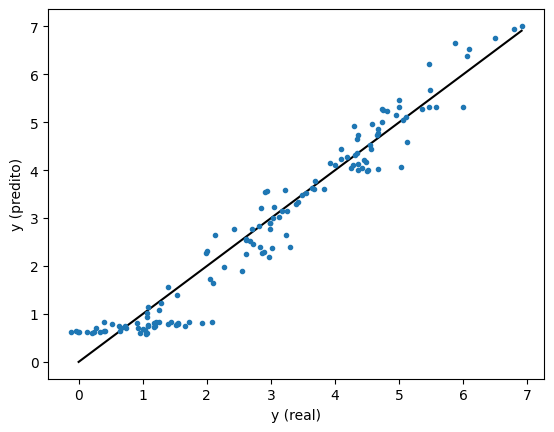

In [31]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test2, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

# Modelo 03 (Algoritmo Adam)

### Instanciação do Modelo 03

In [32]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo3 = MLP(input_dim,output_dim)

### Otimizador

In [33]:
eta = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(modelo3.parameters(),lr=eta)

### Treinamento

In [34]:
num_epochs = 10000
train_losses3 = np.zeros(num_epochs)
val_losses3  = np.zeros(num_epochs)

train_network(modelo3,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses3,val_losses3)

Epoch 500/10000, Erro Treino: 0.1936,  Erro Validação: 0.614
Epoch 1000/10000, Erro Treino: 0.0555,  Erro Validação: 0.335
Epoch 1500/10000, Erro Treino: 0.0489,  Erro Validação: 0.326
Epoch 2000/10000, Erro Treino: 0.0362,  Erro Validação: 0.378
Epoch 2500/10000, Erro Treino: 0.0308,  Erro Validação: 0.301
Epoch 3000/10000, Erro Treino: 0.0267,  Erro Validação: 0.246
Epoch 3500/10000, Erro Treino: 0.0208,  Erro Validação: 0.300
Epoch 4000/10000, Erro Treino: 0.0240,  Erro Validação: 0.364
Epoch 4500/10000, Erro Treino: 0.0155,  Erro Validação: 0.415
Epoch 5000/10000, Erro Treino: 0.0137,  Erro Validação: 0.462
Epoch 5500/10000, Erro Treino: 0.0104,  Erro Validação: 0.531
Epoch 6000/10000, Erro Treino: 0.0083,  Erro Validação: 0.598
Epoch 6500/10000, Erro Treino: 0.0079,  Erro Validação: 0.661
Epoch 7000/10000, Erro Treino: 0.0131,  Erro Validação: 0.647
Epoch 7500/10000, Erro Treino: 0.0071,  Erro Validação: 0.608
Epoch 8000/10000, Erro Treino: 0.0086,  Erro Validação: 0.656
Epoch 850

## Resultados

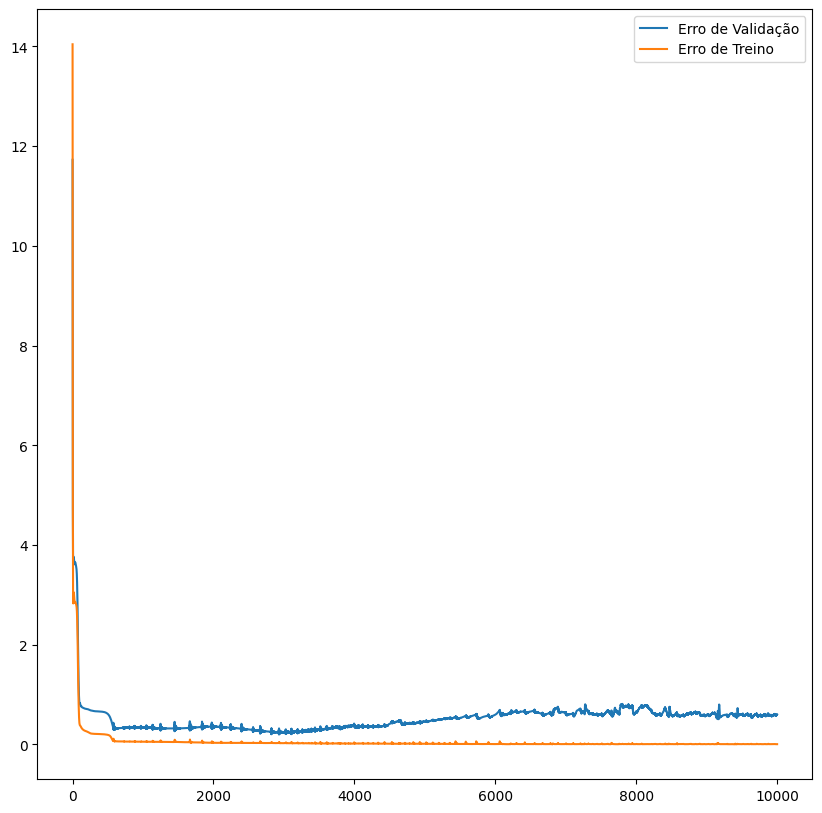

In [35]:
plt.figure(figsize=(10,10))
plt.plot(val_losses3, label='Erro de Validação')
plt.plot(train_losses3, label='Erro de Treino')
plt.legend()
plt.show()

In [36]:
predictions_train3 = []
predictions_val3 = []
predictions_test3 =  []
with torch.no_grad():
    predictions_train3 = modelo3(x_train)
    predictions_val3 = modelo3(x_val)
    predictions_test3 = modelo3(x_test)

erro_train3 = loss_function(predictions_train3,y_train)
erro_val3 = loss_function(predictions_val3,y_val)
erro_test3 = loss_function(predictions_test3,y_test)

print(f"Erro de Treino: {erro_train3}")
print(f"Erro de Validação: {erro_val3}")
print(f"Erro de Teste: {erro_test3}")

Erro de Treino: 0.006409948226064444
Erro de Validação: 0.6025813221931458
Erro de Teste: 0.5195382833480835


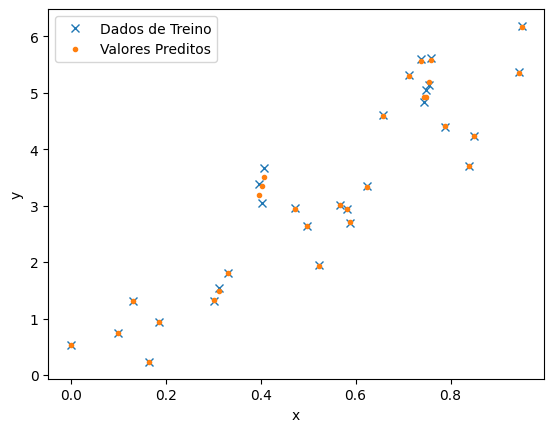

In [37]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train3, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

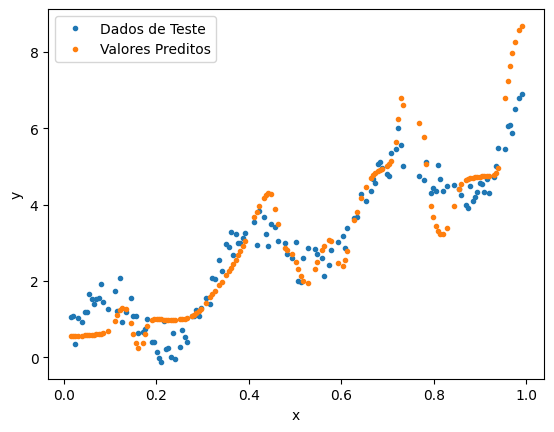

In [38]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test3, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

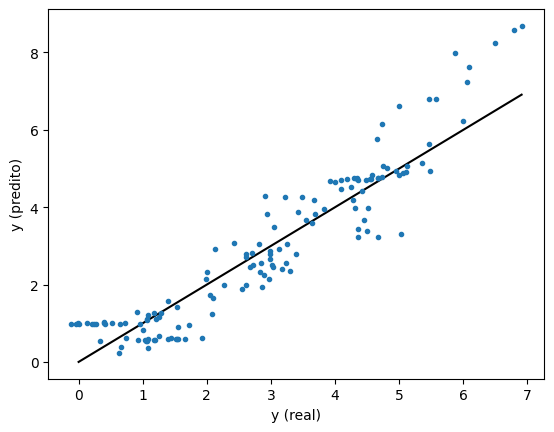

In [39]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test3, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

# Modelo 04 Regularização L2 (baixa)

### Instanciação

In [40]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo4 = MLP(input_dim,output_dim)

### Otimizador

In [41]:
eta = 0.001
loss_function = nn.MSELoss()
# o parametro weight_decay adiciona o 
# termo de regularização L2 à função de custo
optimizer = torch.optim.Adam(modelo4.parameters(),
                             lr=eta, 
                             weight_decay=0.0001)

### Treinamento

In [42]:
num_epochs = 10000
train_losses4 = np.zeros(num_epochs)
val_losses4  = np.zeros(num_epochs)

train_network(modelo4,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses4,val_losses4)

Epoch 500/10000, Erro Treino: 0.2008,  Erro Validação: 0.665
Epoch 1000/10000, Erro Treino: 0.0602,  Erro Validação: 0.321
Epoch 1500/10000, Erro Treino: 0.0523,  Erro Validação: 0.290
Epoch 2000/10000, Erro Treino: 0.0331,  Erro Validação: 0.286
Epoch 2500/10000, Erro Treino: 0.0307,  Erro Validação: 0.223
Epoch 3000/10000, Erro Treino: 0.0282,  Erro Validação: 0.228
Epoch 3500/10000, Erro Treino: 0.0206,  Erro Validação: 0.255
Epoch 4000/10000, Erro Treino: 0.0128,  Erro Validação: 0.305
Epoch 4500/10000, Erro Treino: 0.0127,  Erro Validação: 0.360
Epoch 5000/10000, Erro Treino: 0.0087,  Erro Validação: 0.358
Epoch 5500/10000, Erro Treino: 0.0146,  Erro Validação: 0.390
Epoch 6000/10000, Erro Treino: 0.0134,  Erro Validação: 0.343
Epoch 6500/10000, Erro Treino: 0.0072,  Erro Validação: 0.374
Epoch 7000/10000, Erro Treino: 0.0136,  Erro Validação: 0.358
Epoch 7500/10000, Erro Treino: 0.0080,  Erro Validação: 0.386
Epoch 8000/10000, Erro Treino: 0.0089,  Erro Validação: 0.410
Epoch 850

## Resultados

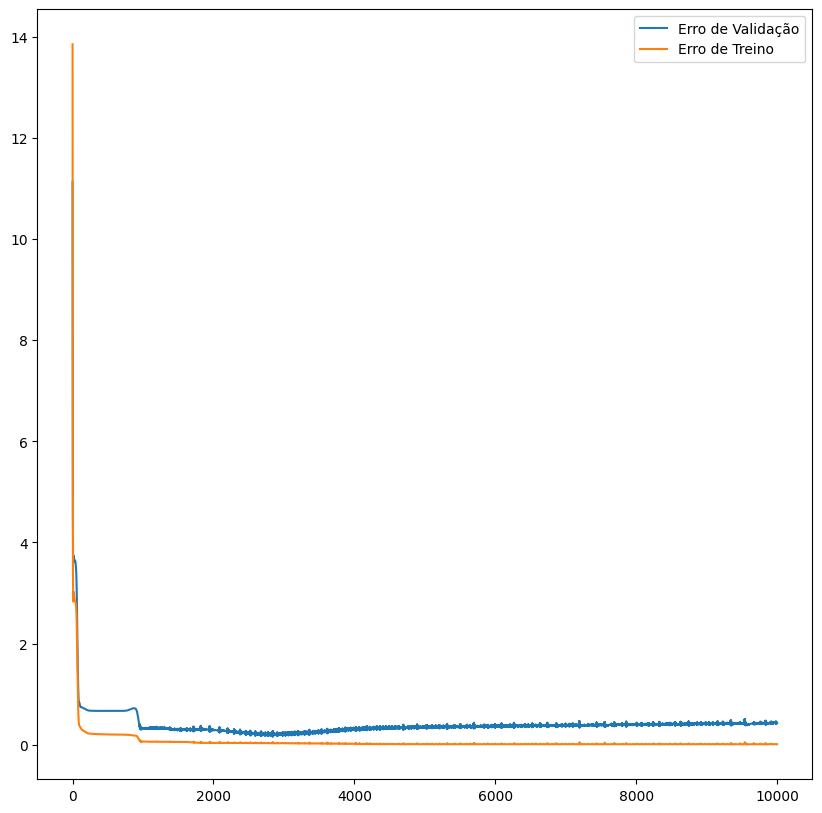

In [43]:
plt.figure(figsize=(10,10))
plt.plot(val_losses4, label='Erro de Validação')
plt.plot(train_losses4, label='Erro de Treino')
plt.legend()
plt.show()

In [44]:
predictions_train4 = []
predictions_val4 = []
predictions_test4 =  []
with torch.no_grad():
    predictions_train4 = modelo4(x_train)
    predictions_val4 = modelo4(x_val)
    predictions_test4 = modelo4(x_test)

erro_train4 = loss_function(predictions_train4,y_train)
erro_val4 = loss_function(predictions_val4,y_val)
erro_test4 = loss_function(predictions_test4,y_test)

print(f"Erro de Treino: {erro_train4}")
print(f"Erro de Validação: {erro_val4}")
print(f"Erro de Teste: {erro_test4}")

Erro de Treino: 0.0070524271577596664
Erro de Validação: 0.42709997296333313
Erro de Teste: 0.5043148994445801


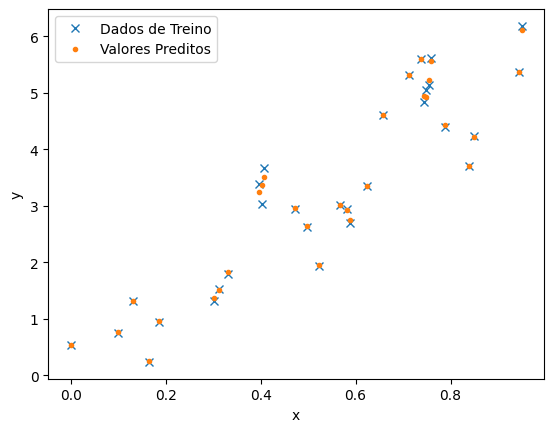

In [45]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train4, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

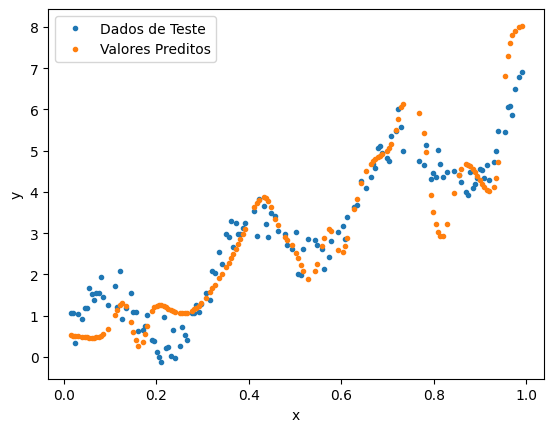

In [46]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test4, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

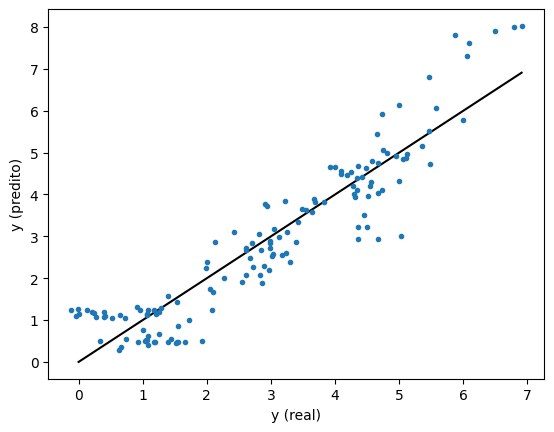

In [47]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test4, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

# Modelo 04 Regularização L2 (alta)

### Instanciação

In [48]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo4B = MLP(input_dim,output_dim)

### Otimizador

In [49]:
eta = 0.001
loss_function = nn.MSELoss()
# o parametro weight_decay adiciona o 
# termo de regularização L2 à função de custo
optimizer = torch.optim.Adam(modelo4B.parameters(),
                             lr=eta, 
                             weight_decay=0.5)

### Treinamento

In [50]:
num_epochs = 3000
train_losses4B = np.zeros(num_epochs)
val_losses4B  = np.zeros(num_epochs)

train_network(modelo4B,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses4B,val_losses4B)

Epoch 500/3000, Erro Treino: 0.5574,  Erro Validação: 0.793
Epoch 1000/3000, Erro Treino: 0.5889,  Erro Validação: 0.765
Epoch 1500/3000, Erro Treino: 0.6459,  Erro Validação: 0.806
Epoch 2000/3000, Erro Treino: 0.6508,  Erro Validação: 0.808
Epoch 2500/3000, Erro Treino: 0.6494,  Erro Validação: 0.809
Epoch 3000/3000, Erro Treino: 0.6475,  Erro Validação: 0.814


## Resultados

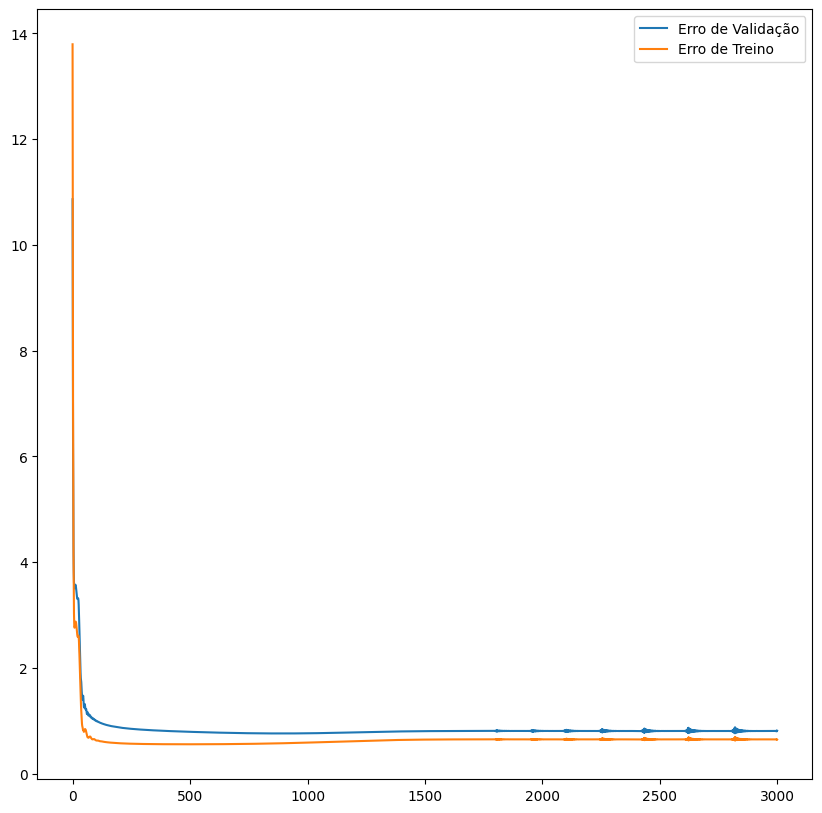

In [51]:
plt.figure(figsize=(10,10))
plt.plot(val_losses4B, label='Erro de Validação')
plt.plot(train_losses4B, label='Erro de Treino')
plt.legend()
plt.show()

In [52]:
predictions_train4B = []
predictions_val4B = []
predictions_test4B =  []
with torch.no_grad():
    predictions_train4B = modelo4B(x_train)
    predictions_val4B = modelo4B(x_val)
    predictions_test4B = modelo4B(x_test)

erro_train4B = loss_function(predictions_train4B,y_train)
erro_val4B = loss_function(predictions_val4B,y_val)
erro_test4B = loss_function(predictions_test4B,y_test)

print(f"Erro de Treino: {erro_train4B}")
print(f"Erro de Validação: {erro_val4B}")
print(f"Erro de Teste: {erro_test4B}")

Erro de Treino: 0.6533395051956177
Erro de Validação: 0.8142531514167786
Erro de Teste: 0.6926464438438416


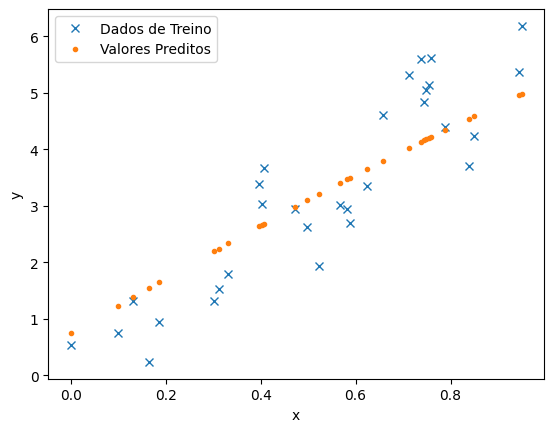

In [53]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train4B, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

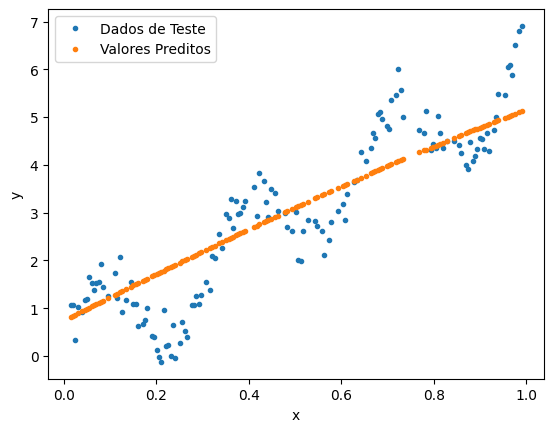

In [54]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test4B, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

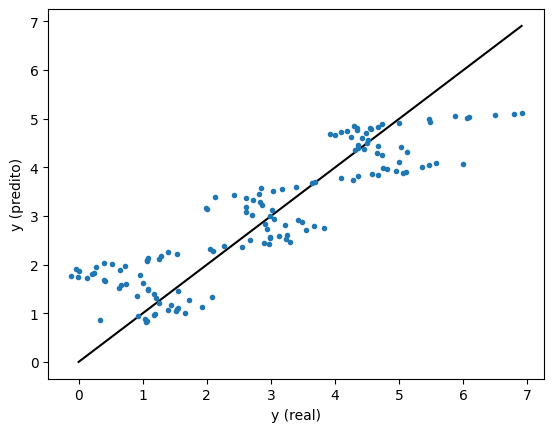

In [55]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test4B, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

# Modelo 04 Regularização L2 (Ok)

### Instanciação

In [56]:
input_dim  = 1 # número de atributos do Iris
output_dim = 1 # número de classes
modelo4C = MLP(input_dim,output_dim)

### Otimizador

In [57]:
eta = 0.001
loss_function = nn.MSELoss()
# o parametro weight_decay adiciona o 
# termo de regularização L2 à função de custo
optimizer = torch.optim.Adam(modelo4C.parameters(),
                             lr=eta, 
                             weight_decay=0.005)

### Treinamento

In [58]:
num_epochs = 3000
train_losses4 = np.zeros(num_epochs)
val_losses4  = np.zeros(num_epochs)

train_network(modelo4C,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses4,val_losses4)

Epoch 500/3000, Erro Treino: 0.2256,  Erro Validação: 0.638
Epoch 1000/3000, Erro Treino: 0.2223,  Erro Validação: 0.630
Epoch 1500/3000, Erro Treino: 0.2123,  Erro Validação: 0.597
Epoch 2000/3000, Erro Treino: 0.2017,  Erro Validação: 0.552
Epoch 2500/3000, Erro Treino: 0.1147,  Erro Validação: 0.363
Epoch 3000/3000, Erro Treino: 0.0784,  Erro Validação: 0.187


## Resultados

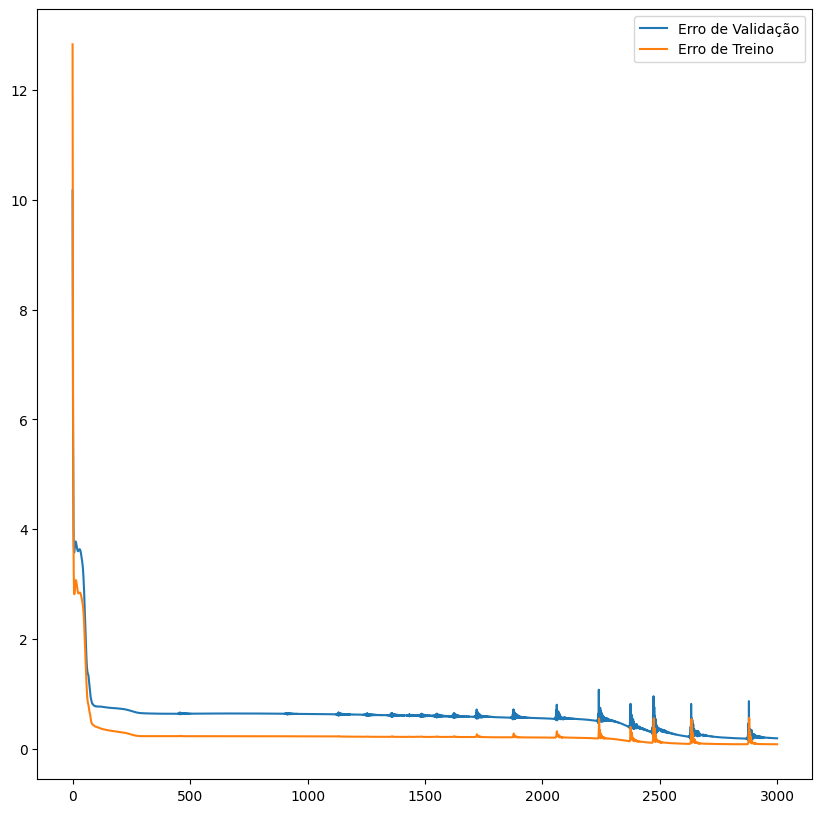

In [59]:
plt.figure(figsize=(10,10))
plt.plot(val_losses4, label='Erro de Validação')
plt.plot(train_losses4, label='Erro de Treino')
plt.legend()
plt.show()

In [60]:
predictions_train4 = []
predictions_val4 = []
predictions_test4 =  []
with torch.no_grad():
    predictions_train4 = modelo4C(x_train)
    predictions_val4 = modelo4C(x_val)
    predictions_test4 = modelo4C(x_test)

erro_train4 = loss_function(predictions_train4,y_train)
erro_val4 = loss_function(predictions_val4,y_val)
erro_test4 = loss_function(predictions_test4,y_test)

print(f"Erro de Treino: {erro_train4}")
print(f"Erro de Validação: {erro_val4}")
print(f"Erro de Teste: {erro_test4}")

Erro de Treino: 0.07833408564329147
Erro de Validação: 0.187306746840477
Erro de Teste: 0.1876872032880783


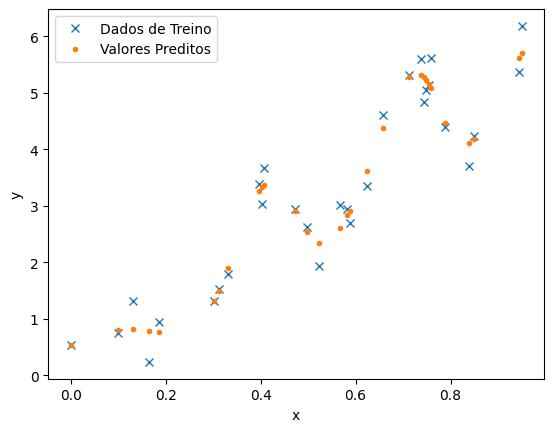

In [61]:
plt.plot(x_train, y_train, 'x', label='Dados de Treino')
plt.plot(x_train, predictions_train4, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

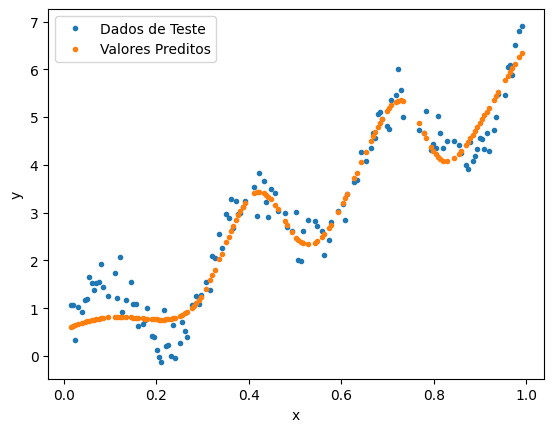

In [62]:
plt.plot(x_test, y_test, '.', label='Dados de Teste')
plt.plot(x_test, predictions_test4, '.', label='Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

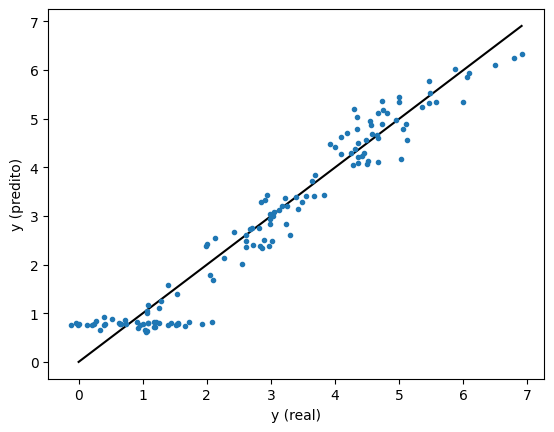

In [63]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test4, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

# Exercício de Apoio

### Realizar as seguintes atividades:


1. Com o algoritmo de otimização Adam, teste outras topologias de rede para o problema de regressão apresentado. Faça uma comparação com os resultados obtidos na semana anterior ao usar o algoritmo SGD
2. Avaliar o impacto da regularização L2 com outros valores e utilizar o Dropout
3. Adapte os modelos acima (ou os modelos da de classificação da semana 03) para outros conjuntos de dados (datasets). Há uma diversidade de datasets para classificação e regressão no próprio Scikit-Learn (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)





